In [8]:
import matplotlib.pyplot as plt

from wfc.utils import load_patterns, generate_patterns, show_tiles
from wfc.wfc import wave_function_collapse

import os.path as osp

# <center>**Simple Tile Model**</center>
This is the Wave Function Collapse demonstration for predefined tiles.\
The constraint here is that adjacent tiles must have the same border.

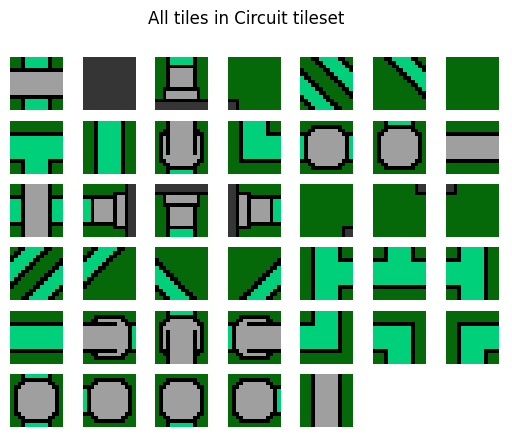

In [9]:
tileset_name = 'Circuit'
tile_folder = osp.join('..', 'images', 'tilesets', tileset_name)
patterns = load_patterns(tile_folder)


fig, axes = show_tiles(patterns)
fig.suptitle(f'All tiles in {tileset_name} tileset')
pass

Wave Function Collapse using the tileset loaded

In [10]:
dim = (10, 30)
result = wave_function_collapse(patterns, dim, repeat_until_success=False)
print(f"All cells collapsed: {result[0]}")

All cells collapsed: True


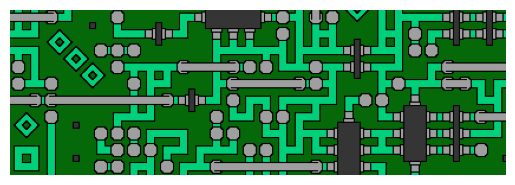

In [11]:
plt.imshow(result[1])
plt.axis('off')
pass

# <center>**Overlapping Model**</center>

Extracted 360 tiles


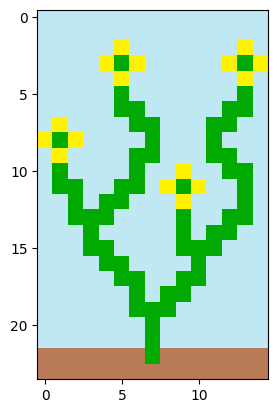

In [2]:
fname = osp.join('..', 'images', 'tileset_generator', 'Flowers.png')
plt.imshow(plt.imread(fname))

patterns = generate_patterns(fname)
print(f"Extracted {len(patterns)} tiles")

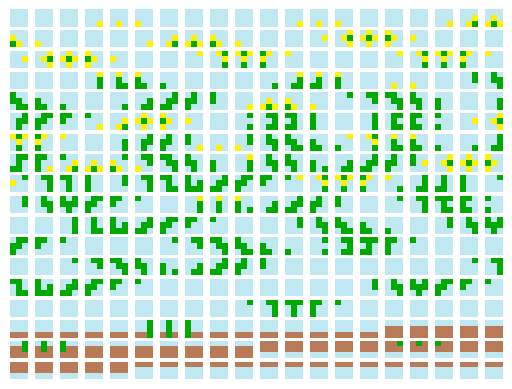

In [3]:
show_tiles(patterns)
pass

In [6]:
result = wave_function_collapse(patterns, (5, 5), repeat_until_success=False)
print(f"All cells collapsed: {result[0]}")

All cells collapsed: True


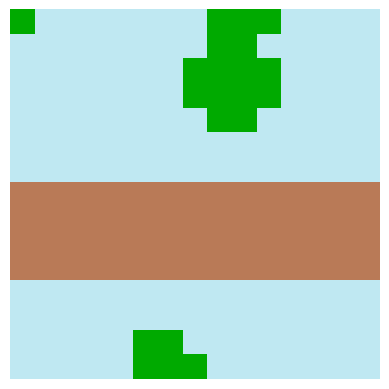

In [7]:
plt.imshow(result[1])
plt.axis('off')
pass